### Merge and combine yearly pitching and batting data

In [83]:
# print(sorted(player_data['Team'].unique()))
# print(sorted(salary_df['Team'].unique()))
p2s_mapping = {
    'ARI': 'ARI',
    'OAK': 'ATH',
    'ATL': 'ATL',
    'BAL': 'BAL',
    'BOS': 'BOS',
    'CHC': 'CHC',
    'CHW': 'CWS',#, cws
    'CIN': 'CIN',
    'CLE': 'CLE',
    'COL': 'COL',
    'DET': 'DET',
    'HOU': 'HOU',
    'KCR': 'KC',
    'LAA': 'LAA',
    'LAD': 'LAD',
    'MIA': 'MIA',
    'MIL': 'MIL',
    'MIN': 'MIN',
    'NYM': 'NYM',
    'NYY': 'NYY',
    'OAK': 'OAK',
    'PHI': 'PHI',
    'PIT': 'PIT',
    'SDP': 'SD',
    'SEA': 'SEA',
    'SFG': 'SF',
    'STL': 'STL',
    'TBR': 'TB',
    'TEX': 'TEX',
    'TOR': 'TOR',
    'WSN': 'WSH'
}

In [84]:
import pandas as pd
import numpy as np

df_list = []
for year in range(2011, 2026):

    df = pd.read_csv(f'stan_batting/stan_batting_{year}.csv', skiprows=1, encoding='utf-8')
    df['Year'] = year
    df_list.append(df)

merged_batting_df = pd.concat(df_list, ignore_index=True)
merged_batting_df.to_csv('stan_batting/merged_stan_batting.csv', index=False)

df_list = []
for year in range(2011, 2026):

    df = pd.read_csv(f'stan_pitching/stan_pitching_{year}.csv', skiprows=1, encoding='utf-8')
    df['Year'] = year
    df_list.append(df)

merged_pitching_df = pd.concat(df_list, ignore_index=True)
merged_pitching_df.to_csv('stan_pitching/merged_stan_pitching.csv', index=False)

# Concatenate two dataframes with different columns, filling missing columns 
# with NaN
concatenated_df = pd.concat([merged_batting_df, merged_pitching_df], ignore_index=True, sort=False)
concatenated_df.rename(columns={'Player': 'Name'}, inplace=True) # rename Player to Name for consistency
concatenated_df['Team'] = concatenated_df['Team'].map(p2s_mapping) # map team names to consistent format
concatenated_df.dropna(subset=['Team'], inplace=True) # drop rows where team is NaN ( average stats and 2/3/4 team players)
concatenated_df.to_csv('merged_batting_pitching.csv', index=False)
concatenated_df

,Rk,Name,Age,Team,Lg,WAR,G,PA,AB,R,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/BB
0,1.0,Jacoby Ellsbury*,27.0,BOS,AL,8.3,158.0,732.0,660.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,Dustin Pedroia,27.0,BOS,AL,8.0,159.0,731.0,635.0,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,Ian Kinsler,29.0,TEX,AL,7.0,155.0,723.0,620.0,121.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,Michael Bourn*,28.0,HOU,NL,2.2,105.0,473.0,429.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,Michael Bourn*,28.0,ATL,NL,0.8,53.0,249.0,227.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32989,855.0,Jayvien Sandridge*,26.0,NYY,AL,-0.1,1.0,NaN,NaN,2.0,...,0.0,6.0,24.0,30.15,4.5,13.5,13.5,27.0,27.0,1.0
32990,856.0,Austin Slater,32.0,NYY,AL,0.0,1.0,NaN,NaN,0.0,...,0.0,3.0,NaN,3.15,1.5,13.5,0.0,0.0,0.0,NaN
32991,857.0,Luis Torrens,29.0,NYM,NL,-0.2,2.0,NaN,NaN,4.0,...,0.0,8.0,12.0,46.65,9.0,67.5,27.0,13.5,0.0,0.0
32993,859.0,Nicky Lopez,30.0,LAA,AL,0.0,1.0,NaN,NaN,0.0,...,0.0,2.0,NaN,12.15,3.0,0.0,0.0,27.0,0.0,0.0


### Build id to merge batting/pitching with salary

In [85]:
import unicodedata

salary_df = pd.read_excel('MLB_Salaries.xlsx')
salary_df.dropna(subset=['Player'], inplace=True) # drop rows where Player is NaN
salary_df = salary_df[['Player','Position','Status','Payroll Salary','Team','Year']]
salary_df.rename(columns={'Payroll Salary': 'Salary'}, inplace=True) # rename Payroll Salary to
player_data = pd.read_csv('merged_batting_pitching.csv', low_memory=False)
def normalize_name(name):
    # Normalize to NFKD and encode to ASCII, ignoring errors (removes accents)
    name =  unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('utf-8')
    name = name.lower().replace('.', '').replace("'", '').strip()
    name = name.rstrip("*#") # remove trailing * or # if present
    return name

salary_df['Name'] = salary_df['Player'].apply(normalize_name)
player_data['Name'] = player_data['Name'].apply(normalize_name)


# create alteration function to get 1st letter of first name and first 3 letters of last name
def convert_name(row):
    parts = row['Name'].split(' ')
    max_idx = (min(1, len(parts[0])))  # Ensure at most 1 characters are taken
    part1 = parts[0][:max_idx]  # First letter of the first name
    part2 = ''
    last_name_len = '0'
    for part in parts[1:]:
        if (len(part)>=3) or (part == parts[-1]): # check that part is either final part or at least 3 characters long
            max_idx = min(4, len(part))  # Ensure at most 4 characters are taken
            part2 = part[:max_idx]  # First three letters of the last name
            last_name_len = str(len(part)) # Length of the last name part
            break # only use the first valid last name part
    team = row['Team']  
    year = row['Year']
    return part1 + part2 + last_name_len + team.lower() + str(year)

salary_df['id'] = salary_df.apply(convert_name, axis=1)
player_data['id'] = player_data.apply(convert_name, axis=1)

# output data to new csv
salary_df.to_csv('mlb_salary_data_with_id.csv', index=False)
player_data.to_csv('merged_batting_pitching_with_id.csv', index=False)

### Test ID

#### Check salary for duplicate ids

In [86]:
from collections import Counter

year = 2024 # limit to single year for testing
print('unique ids in salary: {}'.format(salary_df[salary_df['Year'] == year]['id'].nunique()))
print('unique ids in player_data: {}'.format(player_data[player_data['Year'] == year]['id'].nunique()))

# get df of ids that have multiple instances
def check_doubled_ids(df):
    dfs = []
    for year in range(2011, 2026):
        counter = Counter(df[df['Year'] == year]['id'])
        doubled_ids = [item for item, count in counter.items() if count > 1]
        dfs.append(df[df['id'].isin(doubled_ids) & (df['Year'] == year)])
    df = pd.concat(dfs)
    df.sort_values(by=['id', 'Salary'], ascending=[True, False], inplace=True)
    return df

# if there are two players with the same id keep the one with the higher salary
def keep_higher_salary(df):
    # count the ids that appear more than once in salary_df for the given year
    temp_df = check_doubled_ids(df.copy())
    drop_idxs = []
    for id in temp_df['id'].unique():
        names = temp_df[temp_df.id == id]
        drop_idxs.append(names.index[1:]) # keep the first instance, drop the rest

    drop_idxs_flat = [idx for sublist in drop_idxs for idx in sublist]
    df = df.drop(drop_idxs_flat)
    df = df.reset_index(drop=True)
    return df

salary_df = keep_higher_salary(salary_df)

unique ids in salary: 839
unique ids in player_data: 1648


#### Check that salary matches 1 row in player data

In [87]:
def get_salary_no_data(salary_df, player_df):
    sal_df = salary_df.copy()
    sal_df['player_conection'] = sal_df['id'].apply(lambda x: 1 if x in player_df['id'].values else 0)
    sal_df = sal_df[sal_df['player_conection'] == 0]
    sal_df.sort_values(by=['Year', 'Name'], inplace=True)
    return sal_df[['Name','id', 'Team', 'Year']]

print(len(salary_df))
get_salary_no_data(salary_df, player_data)
# print(len())

14320


,Name,id,Team,Year
14132,adam wainwright,awain10stl2011,STL,2011
14249,adeiny hechavarria,ahech11tor2011,TOR,2011
13592,alberto arias,aaria5hou2011,HOU,2011
13761,alex sanabia,asana7mia2011,MIA,2011
13737,anibal sanchez,asanc7mia2011,MIA,2011
...,...,...,...,...
462,taylor clarke,tclar6mil2024,MIL,2024
675,taylor rogers,troge6sea2024,SEA,2024
697,trevor mcdonald,tmcdo8sea2024,SEA,2024
681,tristan beck,tbeck4sea2024,SEA,2024


### Final Merge

In [88]:
salary_df.to_csv('mlb_salary_data_with_id.csv', index=False)
player_data.to_csv('merged_batting_pitching_with_id.csv', index=False)
final_merge = player_data.merge(salary_df[['id','Position','Status','Salary']], how='left', on='id')
final_merge.dropna(subset=['Salary'], inplace=True) # drop rows where Salary is NaN
final_merge.to_csv('final_merged_player_salary_data.csv', index=False)
final_merge

,Rk,Name,Age,Team,Lg,WAR,G,PA,AB,R,...,WHIP,H9,HR9,BB9,SO9,SO/BB,id,Position,Status,Salary
0,1.0,jacoby ellsbury,27.0,BOS,AL,8.3,158.0,732.0,660.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,jells8bos2011,CF,Arbitration 1,2500000
1,2.0,dustin pedroia,27.0,BOS,AL,8.0,159.0,731.0,635.0,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,dpedr7bos2011,2B,NaN,5750000
2,3.0,ian kinsler,29.0,TEX,AL,7.0,155.0,723.0,620.0,121.0,...,NaN,NaN,NaN,NaN,NaN,NaN,ikins7tex2011,2B,Arbitration 3,6200000
4,4.0,michael bourn,28.0,ATL,NL,0.8,53.0,249.0,227.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,mbour5atl2011,CF,Arbitration 2,1923497
5,5.0,ichiro suzuki,37.0,SEA,AL,0.6,161.0,721.0,677.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,isuzu6sea2011,RF,Veteran,18000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29276,840.0,mike yastrzemski,33.0,SF,NL,-0.1,1.0,NaN,NaN,2.0,...,5.0,18.0,0.0,27.0,0.0,0.0,myast11sf2024,RF,Arbitration 3,7900000
29282,846.0,oswaldo cabrera,25.0,NYY,AL,0.0,1.0,NaN,NaN,0.0,...,6.0,0.0,0.0,54.0,0.0,0.0,ocabr7nyy2024,LF,Pre-Arbitration,783000
29286,850.0,jhonny pereda,28.0,MIA,NL,0.0,1.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,jpere6mia2024,C,Pre-Arbitration,198900
29288,852.0,luis torrens,28.0,NYM,NL,0.0,1.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,ltorr7nym2024,C,Veteran,787097


### Remove batting data for pitchers

In [89]:
df = pd.read_csv('final_merged_player_salary_data.csv', low_memory=False)

df['pitcher'] = 0
df.loc[df.duplicated('id', keep=False), 'pitcher'] = 1
dup_df = df[df.duplicated('id', keep=False)]
dup_df
dup_df[dup_df['BF'].isnull()].index

df.drop(index=dup_df[dup_df['BF'].isnull()].index, inplace=True)
df.to_csv('final_merged_player_salary_data_final.csv', index=False)
df

,Rk,Name,Age,Team,Lg,WAR,G,PA,AB,R,...,H9,HR9,BB9,SO9,SO/BB,id,Position,Status,Salary,pitcher
0,1.0,jacoby ellsbury,27.0,BOS,AL,8.3,158.0,732.0,660.0,119.0,...,NaN,NaN,NaN,NaN,NaN,jells8bos2011,CF,Arbitration 1,2500000,0
1,2.0,dustin pedroia,27.0,BOS,AL,8.0,159.0,731.0,635.0,102.0,...,NaN,NaN,NaN,NaN,NaN,dpedr7bos2011,2B,NaN,5750000,0
2,3.0,ian kinsler,29.0,TEX,AL,7.0,155.0,723.0,620.0,121.0,...,NaN,NaN,NaN,NaN,NaN,ikins7tex2011,2B,Arbitration 3,6200000,0
3,4.0,michael bourn,28.0,ATL,NL,0.8,53.0,249.0,227.0,30.0,...,NaN,NaN,NaN,NaN,NaN,mbour5atl2011,CF,Arbitration 2,1923497,0
4,5.0,ichiro suzuki,37.0,SEA,AL,0.6,161.0,721.0,677.0,80.0,...,NaN,NaN,NaN,NaN,NaN,isuzu6sea2011,RF,Veteran,18000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19016,840.0,mike yastrzemski,33.0,SF,NL,-0.1,1.0,NaN,NaN,2.0,...,18.0,0.0,27.0,0.0,0.0,myast11sf2024,RF,Arbitration 3,7900000,1
19017,846.0,oswaldo cabrera,25.0,NYY,AL,0.0,1.0,NaN,NaN,0.0,...,0.0,0.0,54.0,0.0,0.0,ocabr7nyy2024,LF,Pre-Arbitration,783000,1
19018,850.0,jhonny pereda,28.0,MIA,NL,0.0,1.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,jpere6mia2024,C,Pre-Arbitration,198900,1
19019,852.0,luis torrens,28.0,NYM,NL,0.0,1.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,ltorr7nym2024,C,Veteran,787097,1


### status about data distribution

Rk: 0 nulls


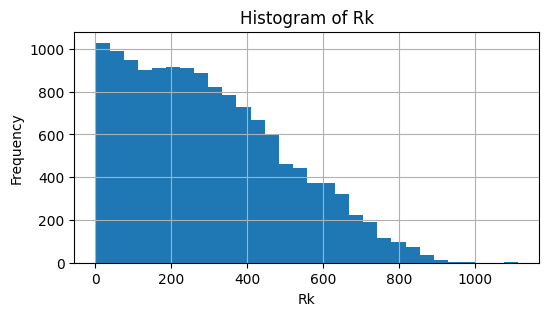

Name: 0 nulls
Age: 0 nulls


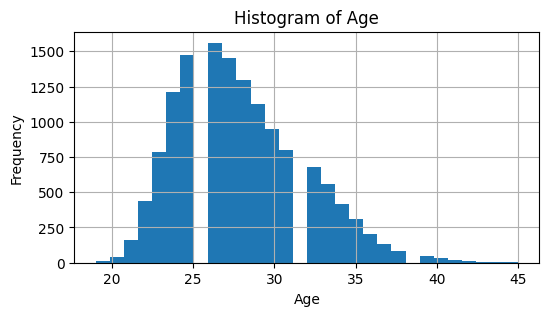

Team: 0 nulls
Lg: 0 nulls


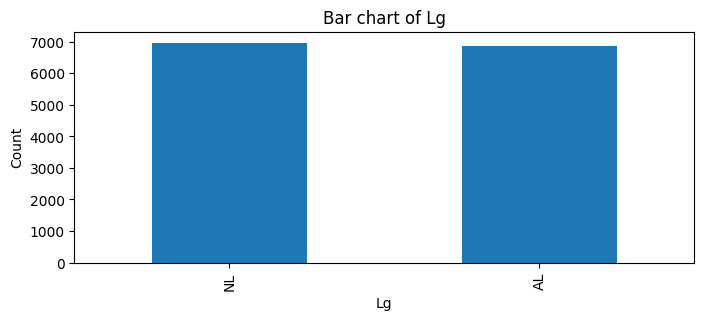

WAR: 0 nulls


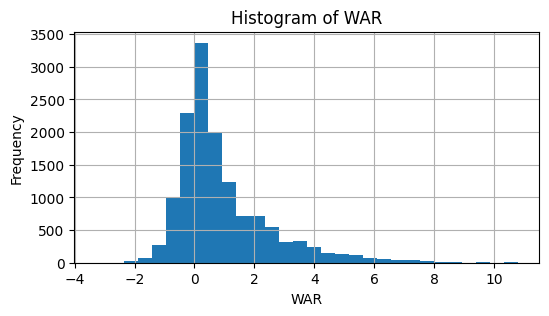

G: 0 nulls


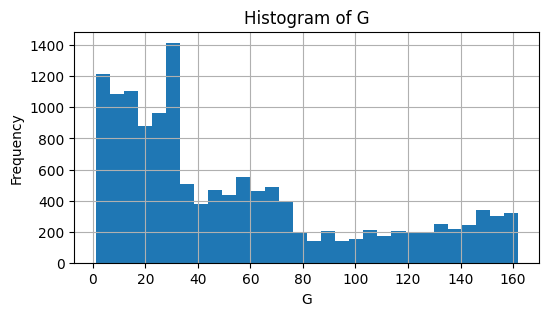

PA: 7377 nulls


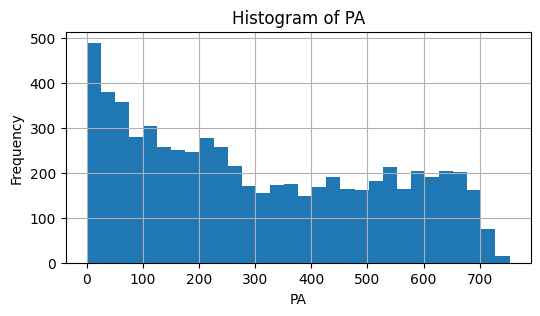

AB: 7377 nulls


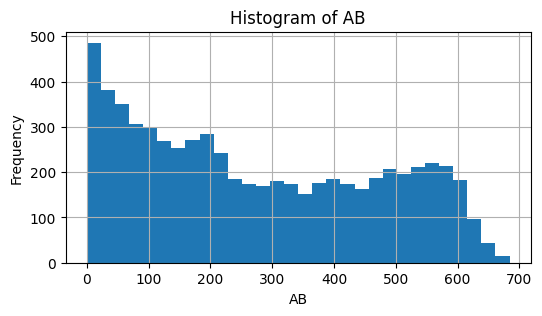

R: 0 nulls


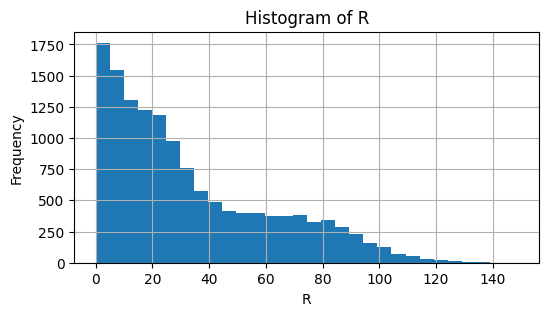

H: 0 nulls


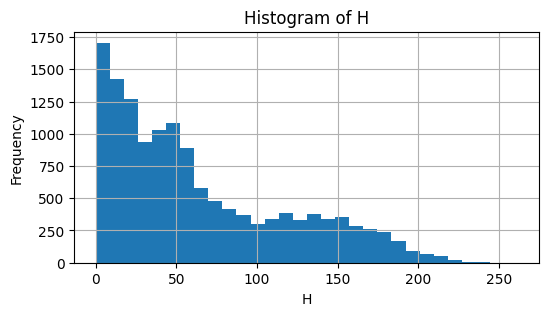

2B: 7377 nulls


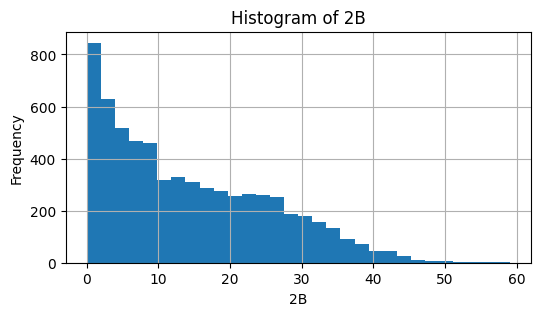

3B: 7377 nulls


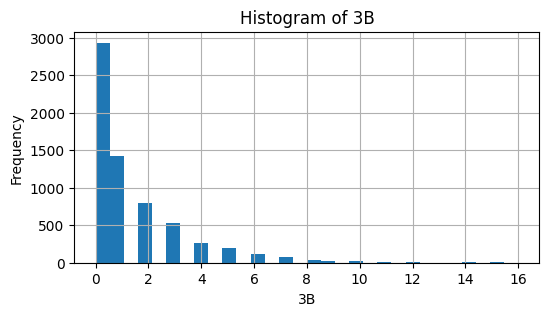

HR: 0 nulls


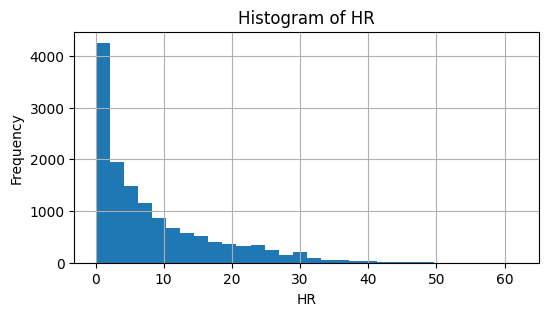

RBI: 7377 nulls


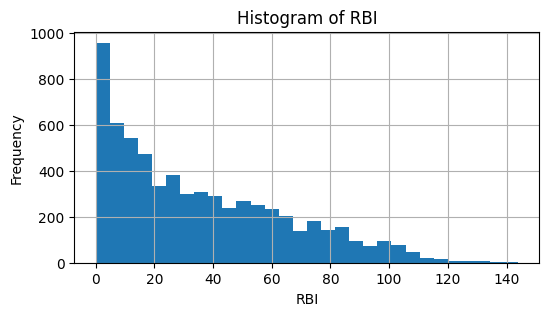

SB: 7377 nulls


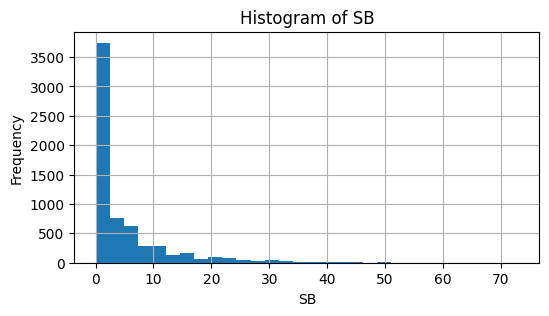

CS: 7377 nulls


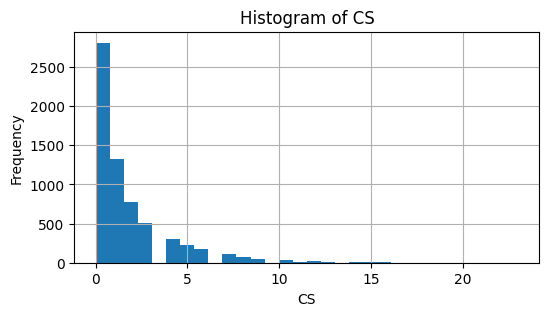

BB: 0 nulls


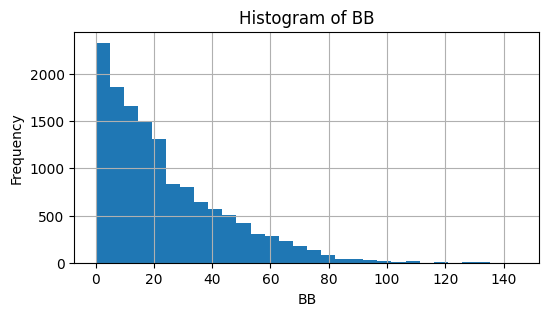

SO: 0 nulls


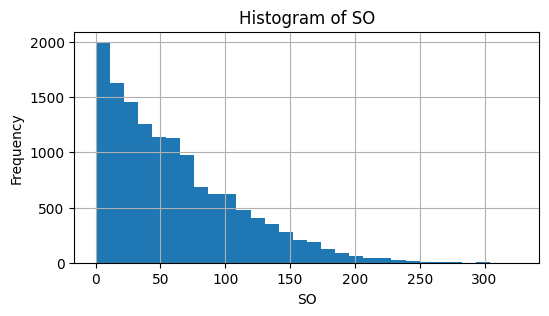

BA: 7383 nulls


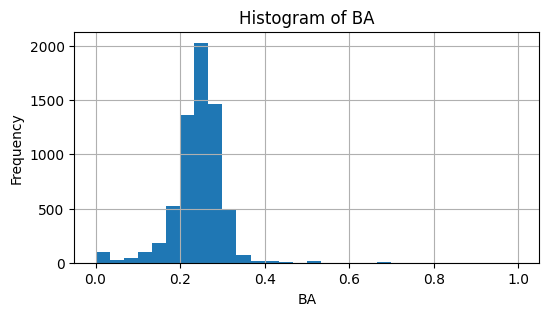

OBP: 7382 nulls


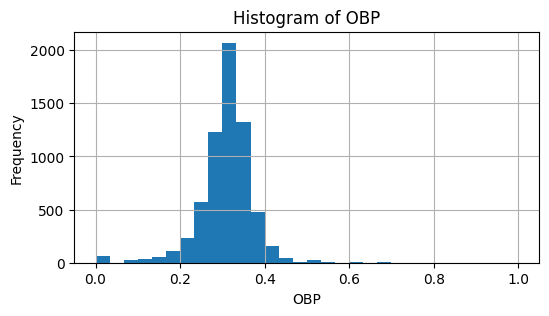

SLG: 7383 nulls


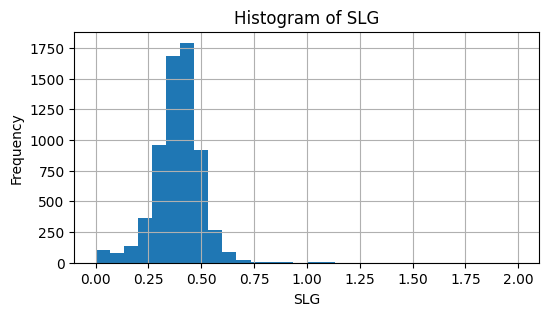

OPS: 7383 nulls


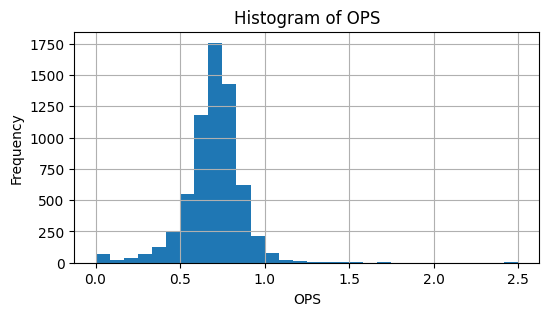

OPS+: 7383 nulls


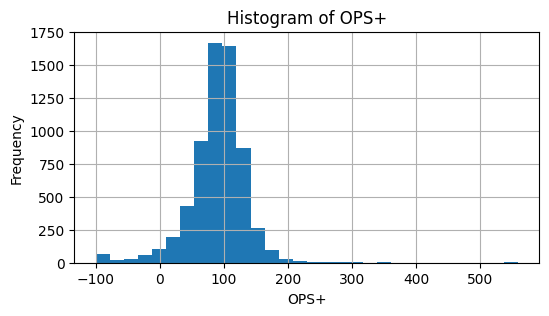

rOBA: 7382 nulls


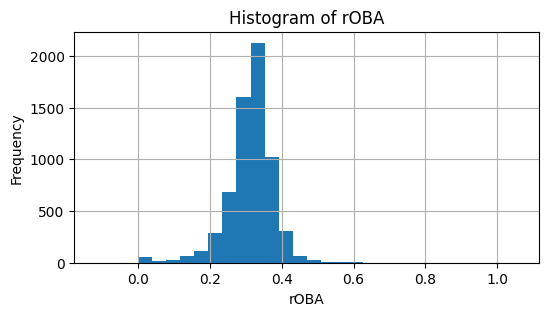

Rbat+: 7382 nulls


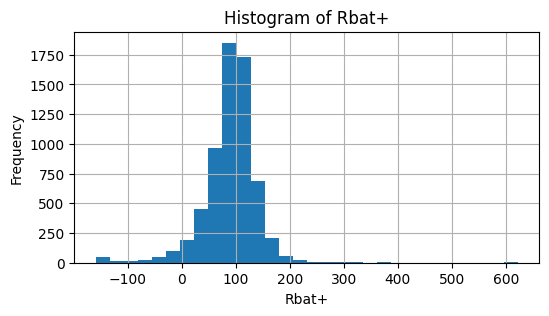

TB: 7377 nulls


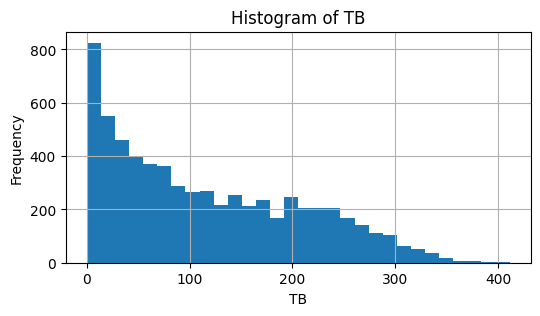

GIDP: 7377 nulls


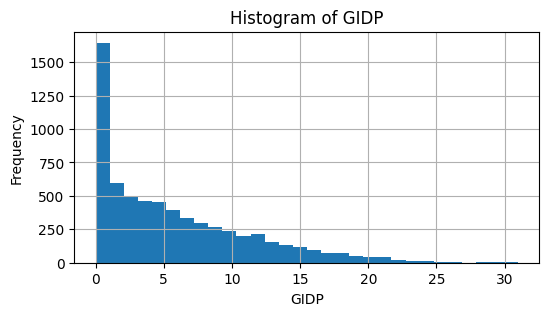

HBP: 0 nulls


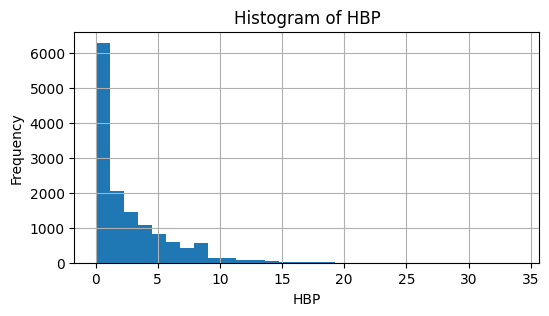

SH: 7377 nulls


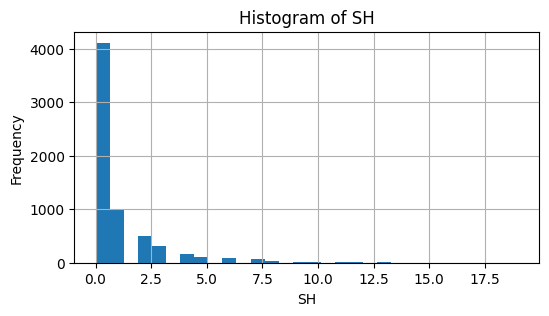

SF: 7377 nulls


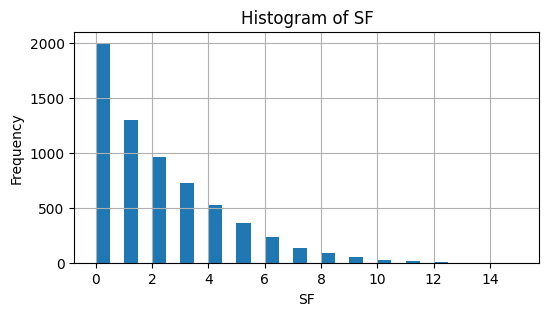

IBB: 0 nulls


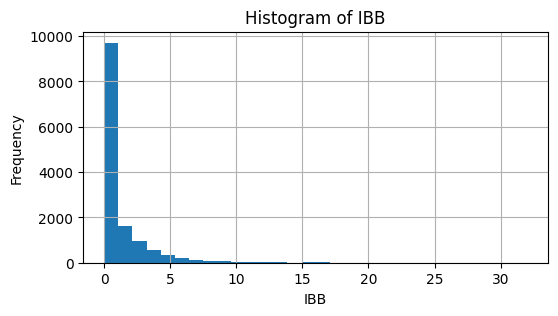

Pos: 7377 nulls
Awards: 12317 nulls
Player-additional: 0 nulls
Year: 0 nulls


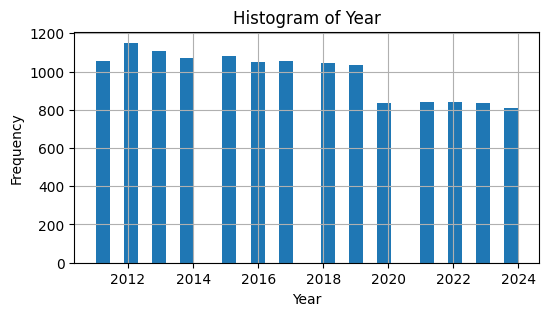

W: 6445 nulls


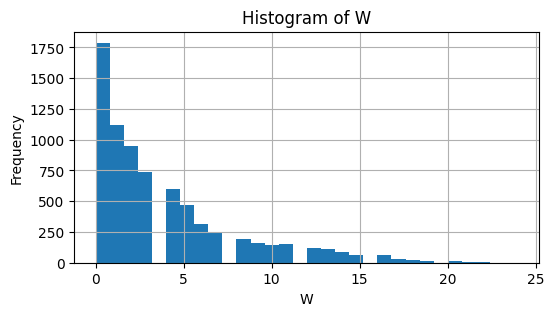

L: 6445 nulls


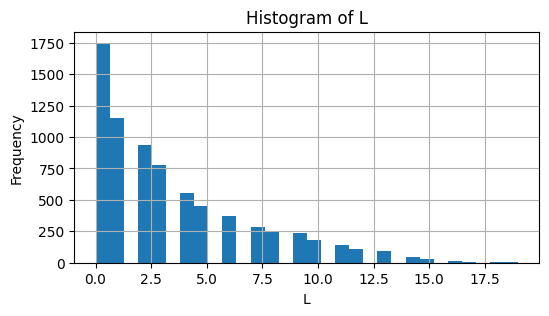

W-L%: 7535 nulls


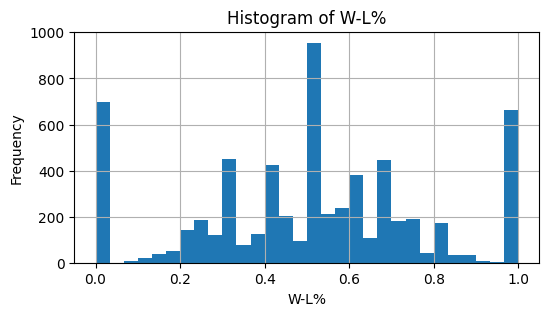

ERA: 6450 nulls


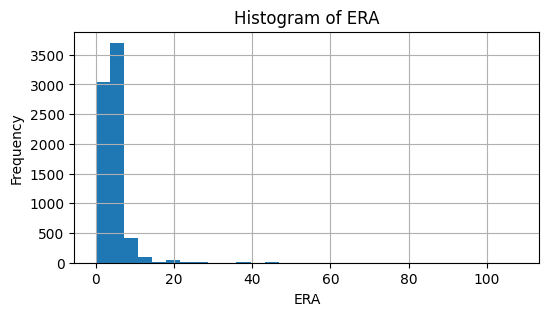

GS: 6445 nulls


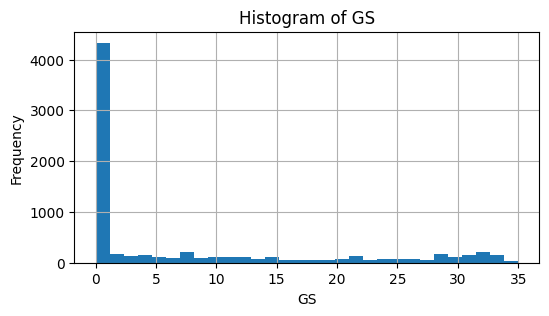

GF: 6445 nulls


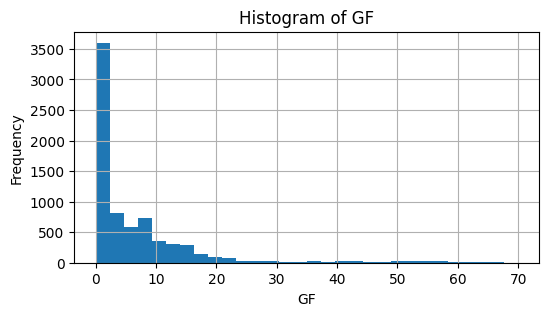

CG: 6445 nulls


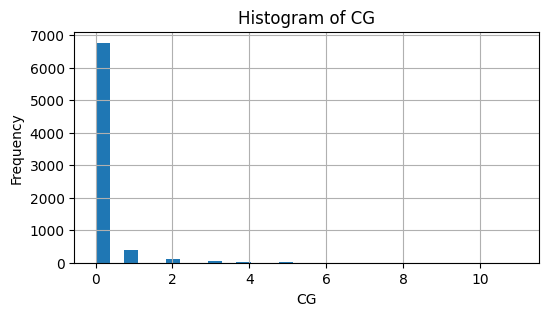

SHO: 6445 nulls


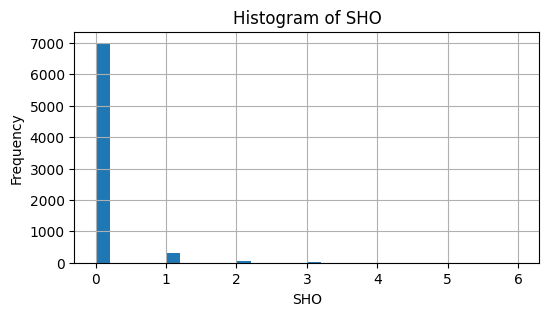

SV: 6445 nulls


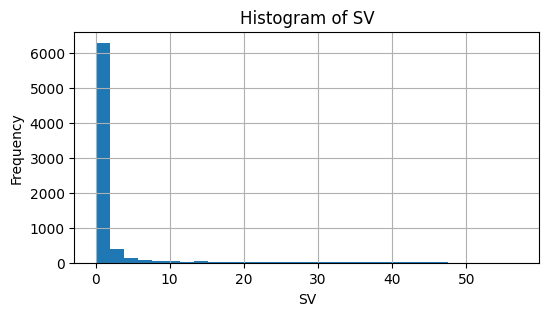

IP: 6445 nulls


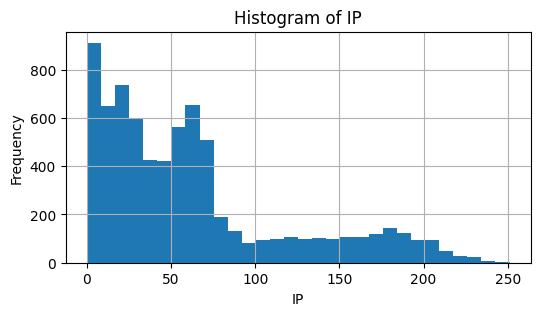

ER: 6445 nulls


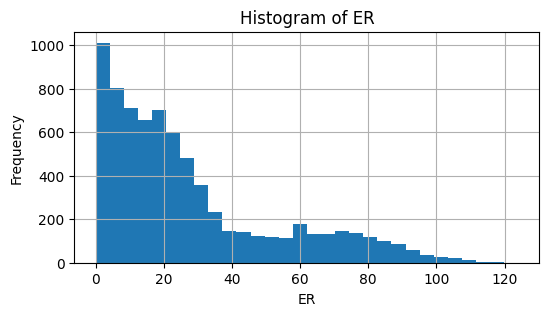

BK: 6445 nulls


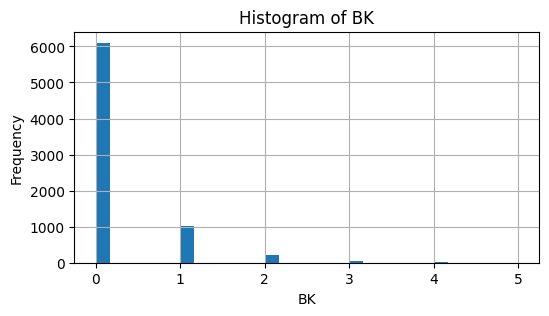

WP: 6445 nulls


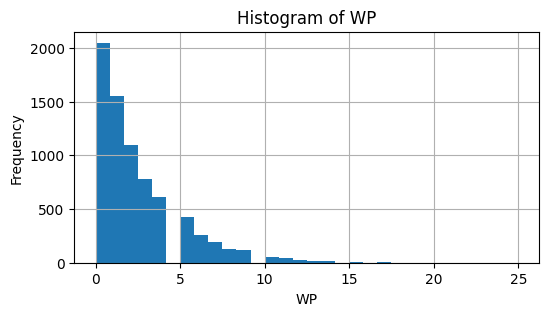

BF: 6445 nulls


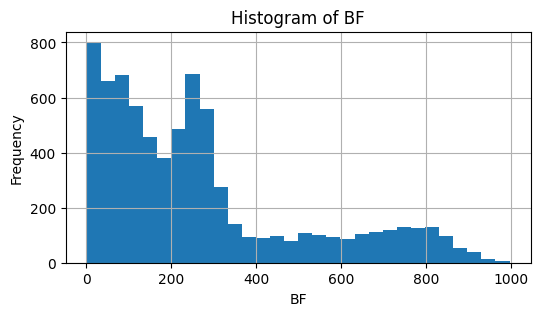

ERA+: 6688 nulls


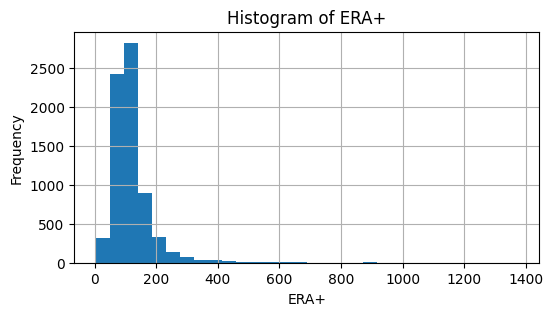

FIP: 6450 nulls


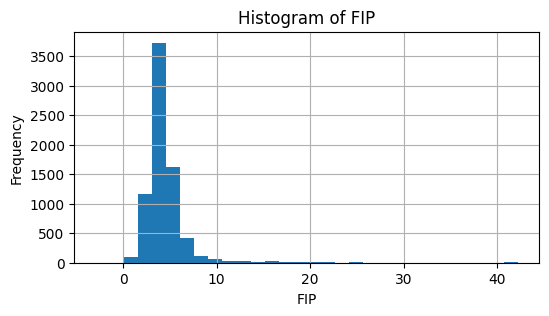

WHIP: 6450 nulls


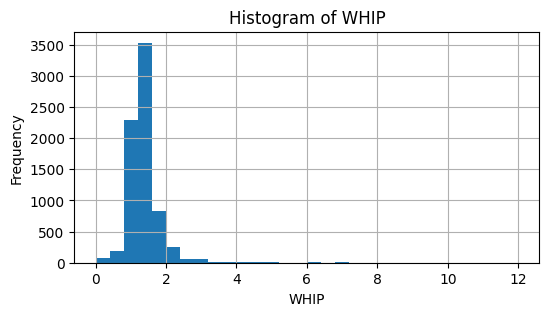

H9: 6450 nulls


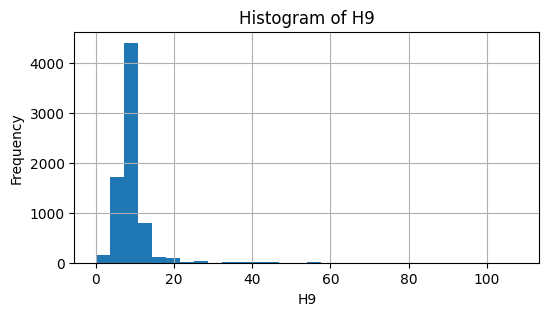

HR9: 6450 nulls


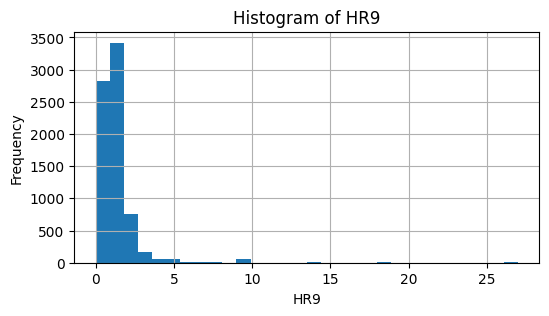

BB9: 6450 nulls


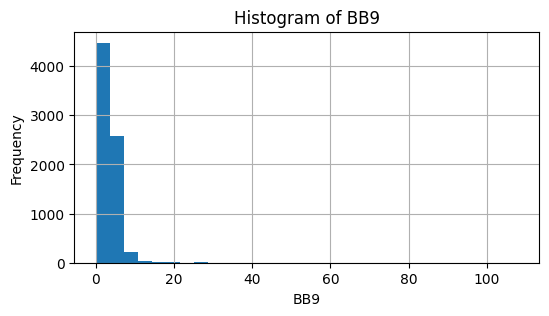

SO9: 6450 nulls


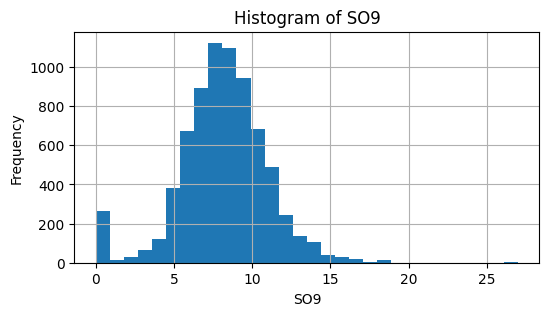

SO/BB: 6729 nulls


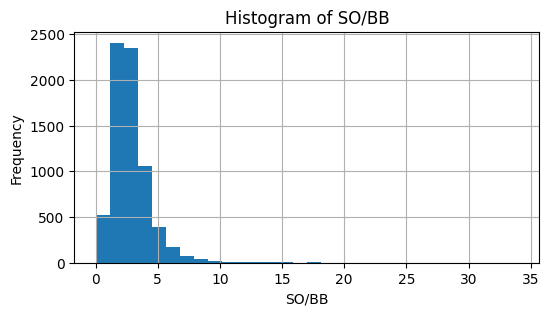

id: 0 nulls
Position: 0 nulls


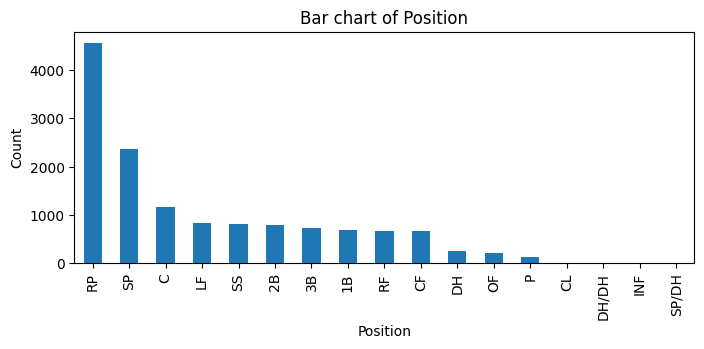

Status: 1761 nulls


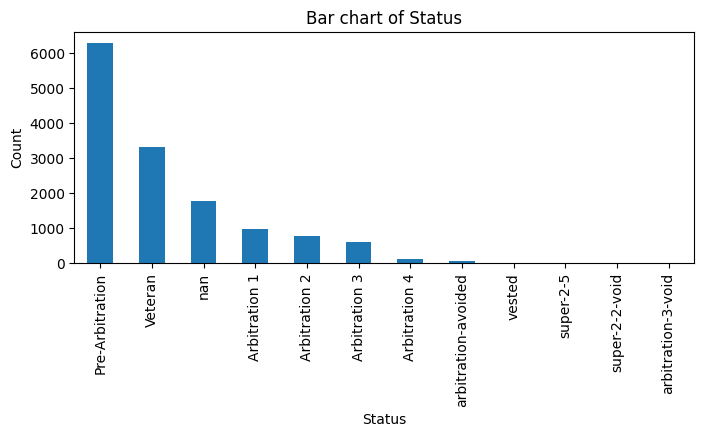

Salary: 0 nulls
pitcher: 0 nulls


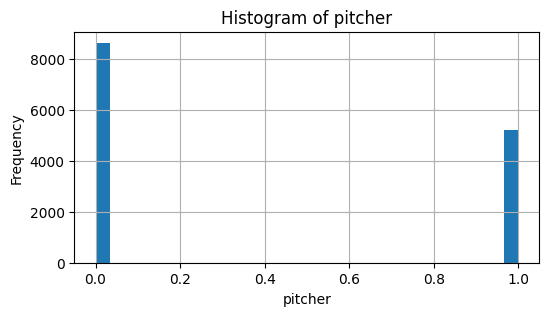

In [90]:
import matplotlib.pyplot as plt

for col in df.columns:
    null_count = df[col].isnull().sum()
    print(f"{col}: {null_count} nulls")
    if df[col].dtype in ['float64', 'int64']:
        plt.figure(figsize=(6, 3))
        df[col].hist(bins=30)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    elif df[col].dtype == 'object':
        # For categorical/object columns, plot bar chart of value counts if unique values are not too many
        unique_vals = df[col].nunique(dropna=True)
        if unique_vals < 30:
            plt.figure(figsize=(8, 3))
            df[col].value_counts(dropna=False).plot(kind='bar')
            plt.title(f'Bar chart of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.show()